In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')


import re

from tqdm import tqdm
tqdm.pandas()

from bs4 import BeautifulSoup

import string

from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

from xgboost import DMatrix, train as xgb_train

from sklearn.ensemble import StackingClassifier, VotingClassifier

from fuzzywuzzy import fuzz

from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\write\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\write\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
ps = PorterStemmer()
ws = WordNetLemmatizer()

In [3]:
stop_words = set(stopwords.words('english'))
punc = string.punctuation

In [4]:

def remove_url(text):
    if isinstance(text, str):  # Check if the input is a string
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(r'', text)
    return text  # If not a string, return it unchanged
    
def preprocessing(text):
    
    # removing urls
    text = remove_url(text)

    # remove html tags
    text = BeautifulSoup(text, 'html.parser')
    text = text.get_text()
    if not text.strip():  # Check if text is empty after stripping HTML
        return 'empty_text'

    # tokenizing the text
    text_list = word_tokenize(text)
    if not text_list:  # Check if text is empty after stripping HTML
        return 'empty_text'


    # lowering the words
    for i in range(len(text_list)):
        text_list[i] = text_list[i].lower().strip()

    # removing the stopwords
    filtered_words = []
    for word in text_list:
        if word not in stop_words:
            filtered_words.append(word)

    text_list = filtered_words

    # removing punctuation
    filtered_words = []
    for word in text_list:
        if word not in punc:
            filtered_words.append(word)
    text_list = filtered_words

    # stemming
    for i in range(len(text_list)):
        text_list[i] = text_list[i].replace('ing', '')
        text_list[i] = text_list[i].replace("'s", '')
        text_list[i] = text_list[i].replace("'re", '')
        text_list[i] = text_list[i].replace("'ve", '')
        text_list[i] = text_list[i].replace("'nt", '')
        text_list[i] = ws.lemmatize(text_list[i])

    final_text =  ' '.join(text_list)

    if not final_text.strip():
        return 'empty_text'
    return final_text

In [5]:
def fetch_fuzzy_features(row):
    q1 = str(row['char_len'])
    q2 = str(row['word_len'])

    fuzze_features = [0.0] * 4

    fuzze_features[0] = fuzz.QRatio(q1, q2)
    fuzze_features[1] = fuzz.partial_ratio(q1, q2)
    fuzze_features[2] = fuzz.token_sort_ratio(q1, q2)
    fuzze_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzze_features

In [6]:

def feature_engineering(row):
    row['char_len'] = row['Review'].str.len()
    row['word_len'] = row['Review'].apply(lambda x: len(x.split()))
    row['char_word_len_ratio'] = row['char_len'] / row['word_len']
    row['first_char_len'] = row['Review'].apply(lambda x: len(x.split()[0]))
    row['last_char_len'] = row['Review'].apply(lambda x: len(x.split()[-1]))
    fuzzy_features = row.apply(fetch_fuzzy_features, axis=1)
    row['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
    row['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
    row['fuzz_token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
    row['fuzz_token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))
    return row
    

In [7]:
a = preprocessing("This is the dataset of Amazon analysis https://instagram.com ! this is punc! and?. read reading reads? ")
print(a)

dataset amazon analysis punc read read read


In [8]:
test_df = pd.read_csv('test.csv')

In [9]:
test_df.shape

(400000, 2)

In [10]:
test_df = test_df.sample(30000, random_state=42)

In [11]:
test_df.shape

(30000, 2)

In [12]:
train_df = pd.read_csv('train.csv')

In [13]:
train_df.shape

(3600000, 2)

In [14]:
train_df = train_df.sample(90000, random_state=42)

In [15]:
train_df.shape

(90000, 2)

In [16]:
print(train_df.shape)
print(test_df.shape)

(90000, 2)
(30000, 2)


In [17]:
df = pd.concat([train_df, test_df])

In [18]:
df.shape

(120000, 2)

In [19]:
df.sample(5)

,Label,Review
1527257,2,This book will keep you guessing!: Mrs. Wagene...
2251705,2,Creative Zen V 2 GB Portable Media Player: Ver...
1563604,2,Whale of a show: This was very interesting and...
180135,1,Not what Amazon promised: This was listed unde...
2445936,1,La música es horrible: Este álbum es muy malo....


In [20]:
df['Label'].unique()

array([1, 2], dtype=int64)

In [21]:
df['Label'] = df['Label'].progress_apply(lambda x: 0 if x == 1 else 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:00<00:00, 648663.90it/s]


In [22]:
df.isnull().sum()

Label     0
Review    0
dtype: int64

In [23]:
df.head(5)

,Label,Review
2079998,0,Expensive Junk: This product consists of a pie...
1443106,0,"Toast too dark: Even on the lowest setting, th..."
3463669,1,Excellent imagery...dumbed down story: I enjoy...
2914699,0,Are we pretending everyone is married?: The au...
1603231,0,Not worth your time: Might as well just use a ...


In [24]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [25]:
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Feature Engineering

In [26]:
df.head()

,Label,Review
2079998,0,Expensive Junk: This product consists of a pie...
1443106,0,"Toast too dark: Even on the lowest setting, th..."
3463669,1,Excellent imagery...dumbed down story: I enjoy...
2914699,0,Are we pretending everyone is married?: The au...
1603231,0,Not worth your time: Might as well just use a ...


In [27]:
df['char_len'] = df['Review'].str.len()

In [28]:
df.head()

,Label,Review,char_len
2079998,0,Expensive Junk: This product consists of a pie...,623
1443106,0,"Toast too dark: Even on the lowest setting, th...",207
3463669,1,Excellent imagery...dumbed down story: I enjoy...,410
2914699,0,Are we pretending everyone is married?: The au...,382
1603231,0,Not worth your time: Might as well just use a ...,124


In [29]:
df['word_len'] = df['Review'].progress_apply(lambda x: len(x.split()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:01<00:00, 103382.70it/s]


In [30]:
df.head()

,Label,Review,char_len,word_len
2079998,0,Expensive Junk: This product consists of a pie...,623,101
1443106,0,"Toast too dark: Even on the lowest setting, th...",207,39
3463669,1,Excellent imagery...dumbed down story: I enjoy...,410,70
2914699,0,Are we pretending everyone is married?: The au...,382,65
1603231,0,Not worth your time: Might as well just use a ...,124,25


In [31]:
df['char_word_len_ratio'] = df['char_len'] / df['word_len']

In [32]:
df.head()

,Label,Review,char_len,word_len,char_word_len_ratio
2079998,0,Expensive Junk: This product consists of a pie...,623,101,6.168317
1443106,0,"Toast too dark: Even on the lowest setting, th...",207,39,5.307692
3463669,1,Excellent imagery...dumbed down story: I enjoy...,410,70,5.857143
2914699,0,Are we pretending everyone is married?: The au...,382,65,5.876923
1603231,0,Not worth your time: Might as well just use a ...,124,25,4.960000


In [33]:
df['first_char_len'] = df['Review'].progress_apply(lambda x: len(x.split()[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:01<00:00, 110013.06it/s]


In [34]:
df.head()

,Label,Review,char_len,word_len,char_word_len_ratio,first_char_len
2079998,0,Expensive Junk: This product consists of a pie...,623,101,6.168317,9
1443106,0,"Toast too dark: Even on the lowest setting, th...",207,39,5.307692,5
3463669,1,Excellent imagery...dumbed down story: I enjoy...,410,70,5.857143,9
2914699,0,Are we pretending everyone is married?: The au...,382,65,5.876923,3
1603231,0,Not worth your time: Might as well just use a ...,124,25,4.960000,3


In [35]:
df['last_char_len'] = df['Review'].progress_apply(lambda x: len(x.split()[-1]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:01<00:00, 110389.71it/s]


In [36]:
df.head()

,Label,Review,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len
2079998,0,Expensive Junk: This product consists of a pie...,623,101,6.168317,9,5
1443106,0,"Toast too dark: Even on the lowest setting, th...",207,39,5.307692,5,10
3463669,1,Excellent imagery...dumbed down story: I enjoy...,410,70,5.857143,9,3
2914699,0,Are we pretending everyone is married?: The au...,382,65,5.876923,3,3
1603231,0,Not worth your time: Might as well just use a ...,124,25,4.960000,3,8


In [37]:
fuzzy_features = df.progress_apply(fetch_fuzzy_features, axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:11<00:00, 10034.37it/s]


In [38]:
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))

In [39]:
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))

In [40]:
df['fuzz_token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))

In [41]:
df['fuzz_token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [42]:
df.head()

,Label,Review,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
2079998,0,Expensive Junk: This product consists of a pie...,623,101,6.168317,9,5,0,0,0,0
1443106,0,"Toast too dark: Even on the lowest setting, th...",207,39,5.307692,5,10,0,0,0,0
3463669,1,Excellent imagery...dumbed down story: I enjoy...,410,70,5.857143,9,3,40,50,40,40
2914699,0,Are we pretending everyone is married?: The au...,382,65,5.876923,3,3,0,0,0,0
1603231,0,Not worth your time: Might as well just use a ...,124,25,4.960000,3,8,40,50,40,40


### Data analysis

char_len


C:\Users\write\AppData\Local\Temp\ipykernel_8900\3049779150.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['char_len'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\3049779150.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 0]

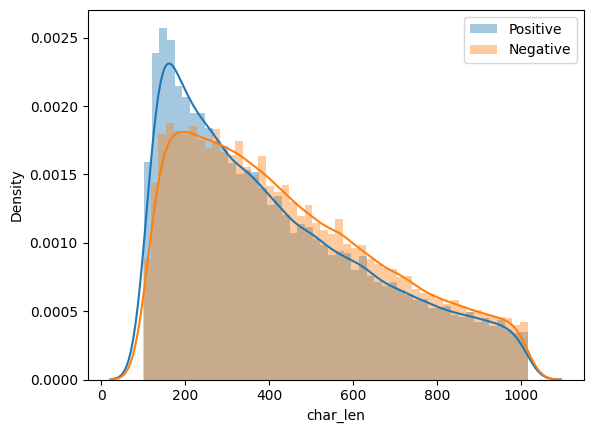

In [43]:
print('char_len')
sns.distplot(df[df['Label'] == 1]['char_len'], label='Positive')
sns.distplot(df[df['Label'] == 0]['char_len'], label='Negative')

plt.legend()

word_len


C:\Users\write\AppData\Local\Temp\ipykernel_8900\830522520.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['word_len'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\830522520.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 0]['

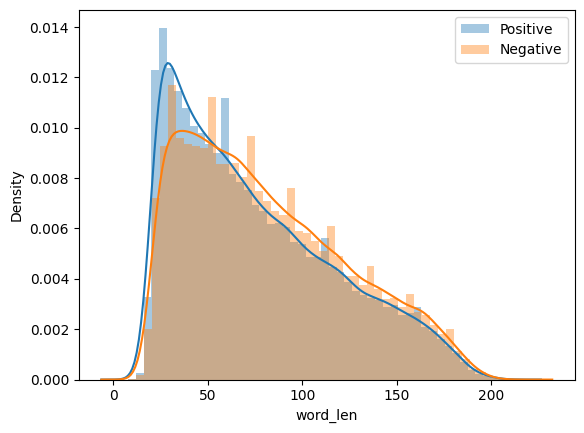

In [44]:
print('word_len')
sns.distplot(df[df['Label'] == 1]['word_len'], label='Positive')
sns.distplot(df[df['Label'] == 0]['word_len'], label='Negative')

plt.legend()

char_word_len_ratio


C:\Users\write\AppData\Local\Temp\ipykernel_8900\3368765356.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['char_word_len_ratio'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\3368765356.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['La

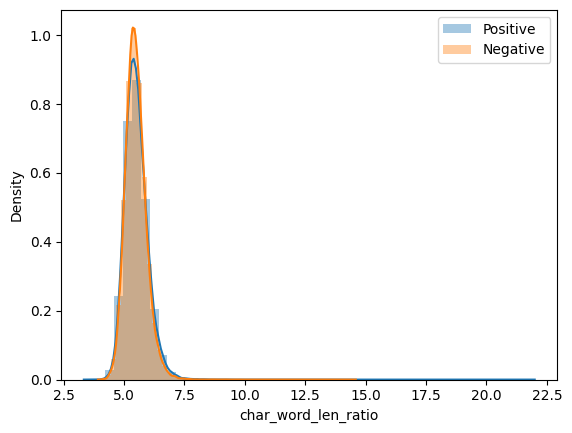

In [45]:
print('char_word_len_ratio')
sns.distplot(df[df['Label'] == 1]['char_word_len_ratio'], label='Positive')
sns.distplot(df[df['Label'] == 0]['char_word_len_ratio'], label='Negative')

plt.legend()

first_char_len


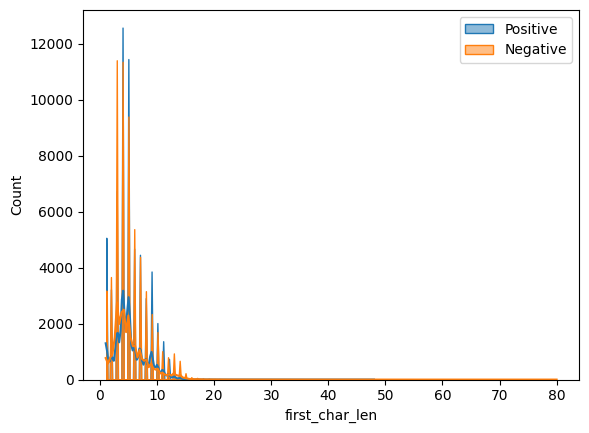

In [46]:
print('first_char_len')
sns.histplot(df[df['Label'] == 1]['first_char_len'], label='Positive', kde=True, element='poly')
sns.histplot(df[df['Label'] == 0]['first_char_len'], label='Negative', kde=True, element='poly')

plt.legend()
plt.show()

last_char_len


C:\Users\write\AppData\Local\Temp\ipykernel_8900\1288512297.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['last_char_len'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\1288512297.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] 

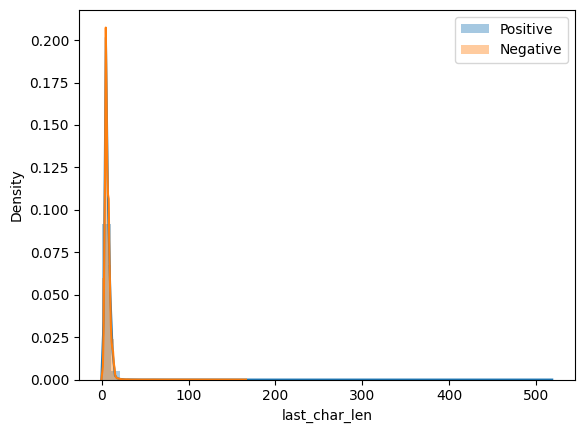

In [47]:
print('last_char_len')

sns.distplot(df[df['Label'] == 1]['last_char_len'], label='Positive')
sns.distplot(df[df['Label'] == 0]['last_char_len'], label='Negative')

plt.legend()

fuzz_ratio


C:\Users\write\AppData\Local\Temp\ipykernel_8900\871580030.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['fuzz_ratio'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\871580030.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 0]

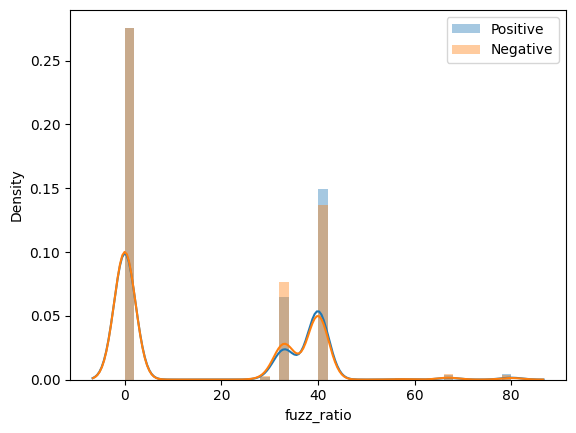

In [48]:
print('fuzz_ratio')

sns.distplot(df[df['Label'] == 1]['fuzz_ratio'], label='Positive')
sns.distplot(df[df['Label'] == 0]['fuzz_ratio'], label='Negative')

plt.legend()

fuzz_partial_ratio


C:\Users\write\AppData\Local\Temp\ipykernel_8900\650349939.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['fuzz_partial_ratio'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\650349939.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label

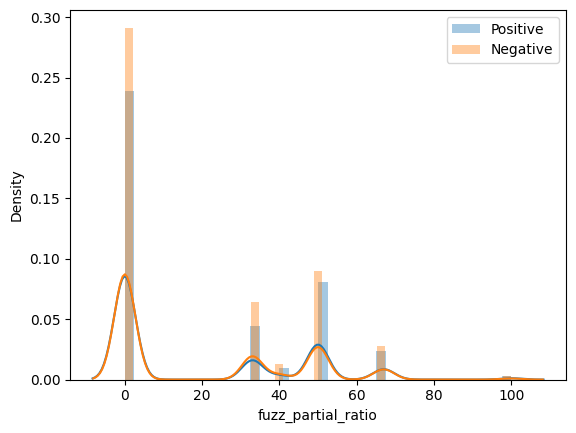

In [49]:
print('fuzz_partial_ratio')
sns.distplot(df[df['Label'] == 1]['fuzz_partial_ratio'], label='Positive')
sns.distplot(df[df['Label'] == 0]['fuzz_partial_ratio'], label='Negative')

plt.legend()

fuzz_partial_ratio


C:\Users\write\AppData\Local\Temp\ipykernel_8900\2452733385.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['fuzz_token_sort_ratio'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\2452733385.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['

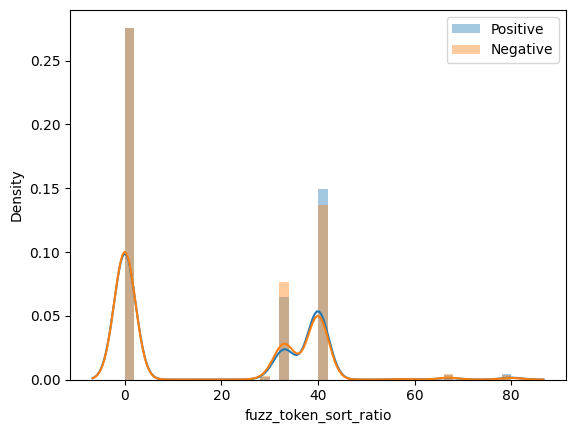

In [50]:
print('fuzz_partial_ratio')
sns.distplot(df[df['Label'] == 1]['fuzz_token_sort_ratio'], label='Positive')
sns.distplot(df[df['Label'] == 0]['fuzz_token_sort_ratio'], label='Negative')

plt.legend()

fuzz_partial_ratio


C:\Users\write\AppData\Local\Temp\ipykernel_8900\3615947629.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['Label'] == 1]['fuzz_token_set_ratio'], label='Positive')
C:\Users\write\AppData\Local\Temp\ipykernel_8900\3615947629.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['L

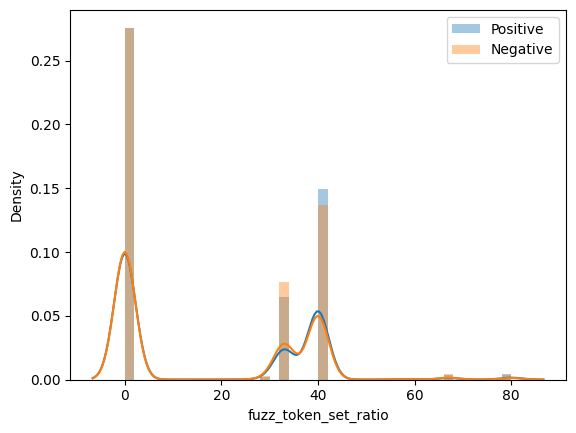

In [51]:
print('fuzz_partial_ratio')
sns.distplot(df[df['Label'] == 1]['fuzz_token_set_ratio'], label='Positive')
sns.distplot(df[df['Label'] == 0]['fuzz_token_set_ratio'], label='Negative')

plt.legend()

In [52]:
df.head()

,Label,Review,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
2079998,0,Expensive Junk: This product consists of a pie...,623,101,6.168317,9,5,0,0,0,0
1443106,0,"Toast too dark: Even on the lowest setting, th...",207,39,5.307692,5,10,0,0,0,0
3463669,1,Excellent imagery...dumbed down story: I enjoy...,410,70,5.857143,9,3,40,50,40,40
2914699,0,Are we pretending everyone is married?: The au...,382,65,5.876923,3,3,0,0,0,0
1603231,0,Not worth your time: Might as well just use a ...,124,25,4.960000,3,8,40,50,40,40


### Tfidf Vectorizer

In [53]:
tfidf = TfidfVectorizer(max_features=5000)

In [54]:
df['Review'] = df['Review'].progress_apply(preprocessing)

  0%|                                                                                                                   | 0/120000 [00:00<?, ?it/s]C:\Users\write\AppData\Local\Temp\ipykernel_8900\2000672662.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser')
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [03:10<00:00, 630.29it/s]


In [55]:
reviews = df['Review'].tolist()

In [56]:
reviews

['expensive junk product consists piece thin flexible insulat material adhesive backed velcro white electrical tape.problems:1 instruction three picture little information.2 velcro crumpled received stronger adhesive tried disengage velcro piece came paint ceil.3 white electrical tape horrible ... cheap narrow fell less 1 hour.4 price ripoff.i build easier use cheaper attractive higher r-value surprised amazon even list junk',
 'toast dark even lowest sett toast dark lik also light stay lit unplug avoid wast electricity quality expected cuisinart',
 'excellent imagery ... dumbed story enjoyed disc video stunn agree others story dumbed take childish approach actually seems like little one sided pro-environmental nevertheless enjoyable would say however amazon wmv hd disc better story better sharper image interest th look',
 'pretend everyone married author pretend parent neither die divorce insist marriage rock upon else behavior well-be child built send clear message non-traditional ho

In [57]:
len(reviews)

120000

In [58]:
reviews_transform = tfidf.fit_transform(reviews).toarray()

In [59]:
reviews_transform

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
reviews_transform.shape

(120000, 5000)

In [61]:
review_temp_df = pd.DataFrame(reviews_transform)

In [62]:
review_temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
review_temp_df.shape

(120000, 5000)

In [64]:
df.head()

,Label,Review,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
2079998,0,expensive junk product consists piece thin fle...,623,101,6.168317,9,5,0,0,0,0
1443106,0,toast dark even lowest sett toast dark lik als...,207,39,5.307692,5,10,0,0,0,0
3463669,1,excellent imagery ... dumbed story enjoyed dis...,410,70,5.857143,9,3,40,50,40,40
2914699,0,pretend everyone married author pretend parent...,382,65,5.876923,3,3,0,0,0,0
1603231,0,worth time might well use knife product hold n...,124,25,4.960000,3,8,40,50,40,40


In [65]:
other_temp_df = df.drop(columns=['Review'])

In [66]:
other_temp_df.head()

,Label,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
2079998,0,623,101,6.168317,9,5,0,0,0,0
1443106,0,207,39,5.307692,5,10,0,0,0,0
3463669,1,410,70,5.857143,9,3,40,50,40,40
2914699,0,382,65,5.876923,3,3,0,0,0,0
1603231,0,124,25,4.960000,3,8,40,50,40,40


In [67]:
type(other_temp_df)

pandas.core.frame.DataFrame

In [68]:
other_temp_df.shape

(120000, 10)

In [69]:
other_temp_df = other_temp_df.reset_index(drop=True)
review_temp_df = review_temp_df.reset_index(drop=True)

In [70]:
final_df = pd.concat([other_temp_df, review_temp_df], axis=1)

In [71]:
final_df

,Label,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,623,101,6.168317,9,5,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,207,39,5.307692,5,10,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,410,70,5.857143,9,3,40,50,40,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,382,65,5.876923,3,3,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,124,25,4.960000,3,8,40,50,40,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,167,24,6.958333,7,5,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119996,1,745,141,5.283688,3,6,33,33,33,33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119997,0,816,167,4.886228,5,5,67,67,67,67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119998,1,391,70,5.585714,7,3,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### train test split

In [72]:
final_df.shape

(120000, 5010)

In [73]:
final_df = final_df.sample(100000, random_state=42)

In [74]:
X = final_df.drop(columns=['Label'])
y = final_df['Label']

In [75]:
X.columns.map(type)

Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'int'>,
       ...
       <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>,
       <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>,
       <class 'int'>, <class 'int'>],
      dtype='object', length=5009)

In [76]:
X.columns = X.columns.astype(str)

In [77]:
X.columns.map(type)

Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>,
       ...
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>],
      dtype='object', length=5009)

In [78]:
y.dtypes

dtype('int64')

In [79]:
y.shape

(100000,)

In [80]:
X.shape

(100000, 5009)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
X_train.shape

(80000, 5009)

In [83]:
X_train.head()

,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,0,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
31407,327,63,5.190476,5,6,40,0,40,40,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87309,165,26,6.346154,5,13,40,50,40,40,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31618,187,37,5.054054,5,12,40,50,40,40,0.0,...,0.0,0.0,0.305948,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23190,326,58,5.620690,1,5,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112391,151,27,5.592593,4,11,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
X_test.shape

(20000, 5009)

In [85]:
X_test.head()

,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,0,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
65913,458,87,5.264368,2,7,40,67,40,40,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27055,216,39,5.538462,4,8,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7628,883,163,5.417178,5,7,33,33,33,33,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82763,566,113,5.008850,3,10,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50559,314,57,5.508772,9,6,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training the model

In [86]:
X_train

,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,0,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
31407,327,63,5.190476,5,6,40,0,40,40,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87309,165,26,6.346154,5,13,40,50,40,40,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31618,187,37,5.054054,5,12,40,50,40,40,0.0,...,0.0,0.0,0.305948,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23190,326,58,5.620690,1,5,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112391,151,27,5.592593,4,11,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87556,884,153,5.777778,1,7,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70025,556,100,5.560000,4,4,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25712,413,75,5.506667,3,7,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7682,153,27,5.666667,6,4,0,0,0,0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### XGBoost

In [87]:
from xgboost import XGBClassifier

In [88]:
xgb = XGBClassifier()

In [89]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [90]:
y_pred = xgb.predict(X_test)

In [91]:
X_train.shape

(80000, 5009)

In [92]:
accuracy_score(y_pred, y_test)

0.8582

In [93]:
chunk_size = 1000
n_chunks = len(X_train) // chunk_size + 1  # To ensure we cover all data

# Train the model incrementally and evaluate after each chunk
for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(X_train))
    
    # Get the current chunk of data
    X_chunk = X_train[start_idx:end_idx]
    y_chunk = y_train[start_idx:end_idx]
    
    if i == 0:
        # First chunk, train the model from scratch
        xgb.fit(X_chunk, y_chunk, verbose=True)
    else:
        # Subsequent chunks, continue training from the previous model
        xgb.fit(X_chunk, y_chunk, xgb_model=xgb.get_booster(), verbose=True)

    # After each chunk, predict on the test set and print the accuracy
    y_pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    print(f"{i}th Accuracy after training on chunk {i+1}: {accuracy}")


0th Accuracy after training on chunk 1: 0.7477
1th Accuracy after training on chunk 2: 0.77315
2th Accuracy after training on chunk 3: 0.76455
3th Accuracy after training on chunk 4: 0.7672
4th Accuracy after training on chunk 5: 0.76425
5th Accuracy after training on chunk 6: 0.7571
6th Accuracy after training on chunk 7: 0.76005
7th Accuracy after training on chunk 8: 0.7633
8th Accuracy after training on chunk 9: 0.76305
9th Accuracy after training on chunk 10: 0.7606
10th Accuracy after training on chunk 11: 0.75285
11th Accuracy after training on chunk 12: 0.7537
12th Accuracy after training on chunk 13: 0.75095
13th Accuracy after training on chunk 14: 0.74775
14th Accuracy after training on chunk 15: 0.7399
15th Accuracy after training on chunk 16: 0.74175
16th Accuracy after training on chunk 17: 0.7459
17th Accuracy after training on chunk 18: 0.74235
18th Accuracy after training on chunk 19: 0.7458
19th Accuracy after training on chunk 20: 0.7384
20th Accuracy after training 

C:\Users\write\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [02:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


80th Accuracy after training on chunk 81: 0.7119


In [94]:
import pickle

In [95]:
with open('model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

In [96]:
with open('tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [97]:
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

In [98]:
with open('tfidf.pkl', 'rb') as file:
    tfidf = pickle.load(file)

In [99]:
a = ['This prodict is worse, unworth to buy']

In [100]:
a_df = pd.DataFrame(a, columns=['Review'])

In [101]:
a_df

,Review
0,"This prodict is worse, unworth to buy"


In [102]:
a_df['Review'] = a_df['Review'].progress_apply(preprocessing)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.07it/s]


In [103]:
a_df

,Review
0,prodict worse unworth buy


In [104]:
a_df = feature_engineering(a_df)

In [105]:
a_df

,Review,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,prodict worse unworth buy,25,4,6.25,7,3,0,0,0,0


In [106]:
a_df.shape

(1, 10)

In [107]:
review_df = a_df['Review']

In [108]:
review_df

0    prodict worse unworth buy
Name: Review, dtype: object

In [109]:
review = tfidf.transform(review_df).toarray()

In [110]:
review_df = pd.DataFrame(review)

In [111]:
review_df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
other_df = a_df.drop(columns=['Review'])

In [113]:
final_df = pd.concat([other_df, review_df], axis=1)

In [114]:
final_df.head()

,char_len,word_len,char_word_len_ratio,first_char_len,last_char_len,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,0,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,25,4,6.25,7,3,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
final_df.shape

(1, 5009)

In [116]:
final_df.columns.map(type)

Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'int'>,
       ...
       <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>,
       <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>,
       <class 'int'>, <class 'int'>],
      dtype='object', length=5009)

In [117]:
final_df.columns = final_df.columns.astype(str)

In [118]:
final_df.columns.map(type)

Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>,
       ...
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>],
      dtype='object', length=5009)

In [119]:
model.predict(final_df)

array([0])